In [15]:
library(forecast)
library(tseries)
library(ggplot2)
library(reshape)
library(zoo)

# Data Load

In [16]:
#============================================================
# Data Load
# - 1949년 ~ 1960년 까지의 월별 비행기 탑승 고객 수
#============================================================ 
origin <- AirPassengers
origin

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1949,112,118,132,129,121,135,148,148,136,119,104,118
1950,115,126,141,135,125,149,170,170,158,133,114,140
1951,145,150,178,163,172,178,199,199,184,162,146,166
1952,171,180,193,181,183,218,230,242,209,191,172,194
1953,196,196,236,235,229,243,264,272,237,211,180,201
1954,204,188,235,227,234,264,302,293,259,229,203,229
1955,242,233,267,269,270,315,364,347,312,274,237,278
1956,284,277,317,313,318,374,413,405,355,306,271,306
1957,315,301,356,348,355,422,465,467,404,347,305,336
1958,340,318,362,348,363,435,491,505,404,359,310,337


In [17]:
class(origin) # ts 객체

[1] "ts"

In [18]:
start(origin)
end(origin)
frequency(origin)

[1] 1949    1

[1] 1960   12

[1] 12

# EDA

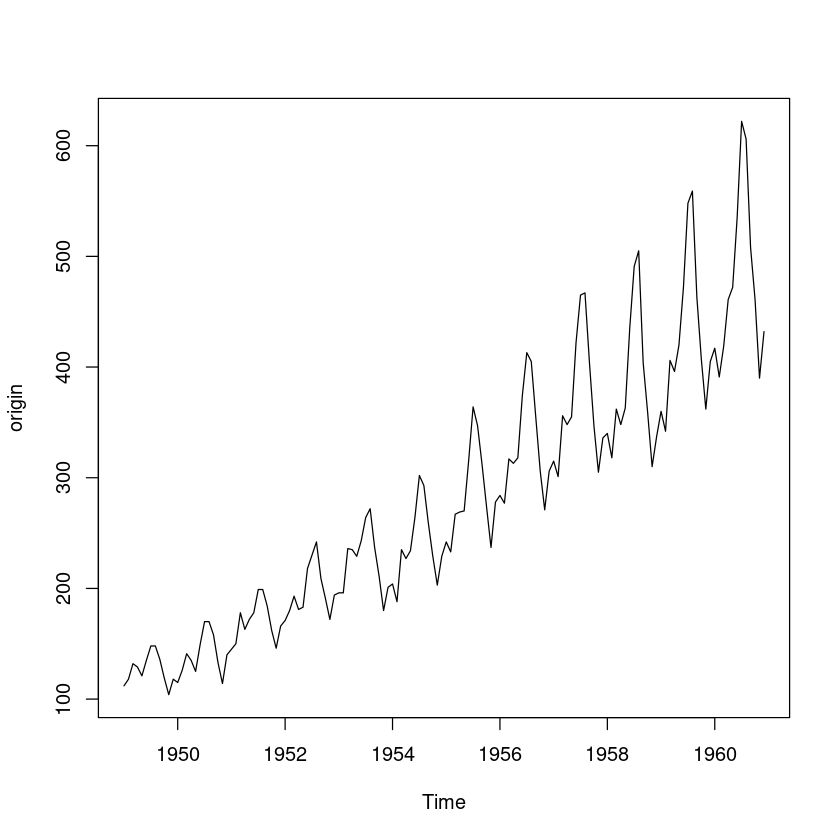

In [19]:
# 시도표
plot(origin)
# 데이터에 이분산이 존재함을 확인일 수 있음
# 분산 안정화를 위한 데이터 변환 필요

- **Boxcox먼저 (등분산) , seasonal, 차분, 계절차분 순서 중요!**

- 차분, 계절차분 순서모를때

시즈널, 트렌드, 분산이상한데 분산맞춰주는게 우산.

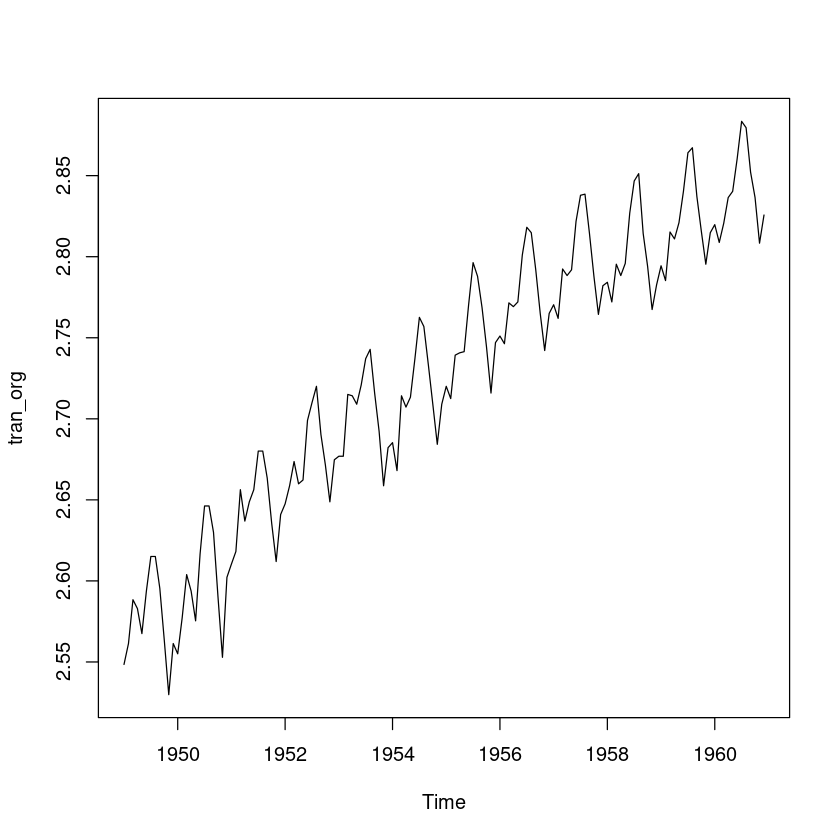

In [6]:
#분산 안정화를 위한 BoxCox 변환
lambda <- BoxCox.lambda(origin)
tran_org <- BoxCox(origin, BoxCox.lambda(origin))
plot(tran_org)
# BoxCox 변환 이후 이분산의 효과가 줄어 든것을 확인

In [87]:
BoxCox.lambda(origin)

[1] -0.2947156

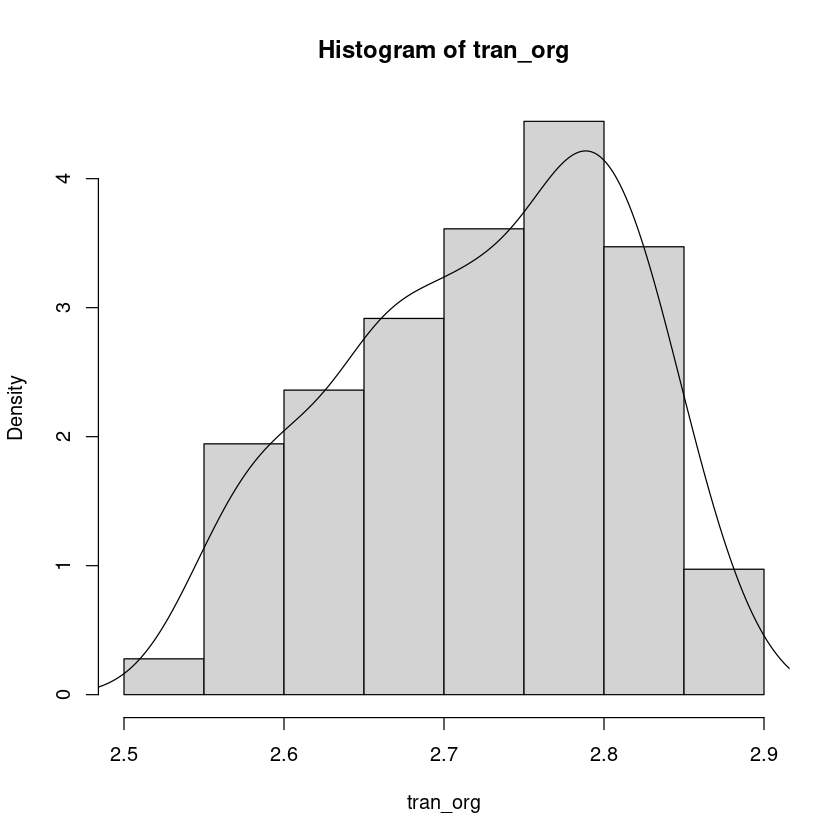

In [21]:
## 질문?
# 정규성 및 Corr
# Hist Plot
hist(tran_org,prob=TRUE,12)
lines(density(tran_org))

**QQ Plot, 정규성 검정 $\to$ 왜하는지?**

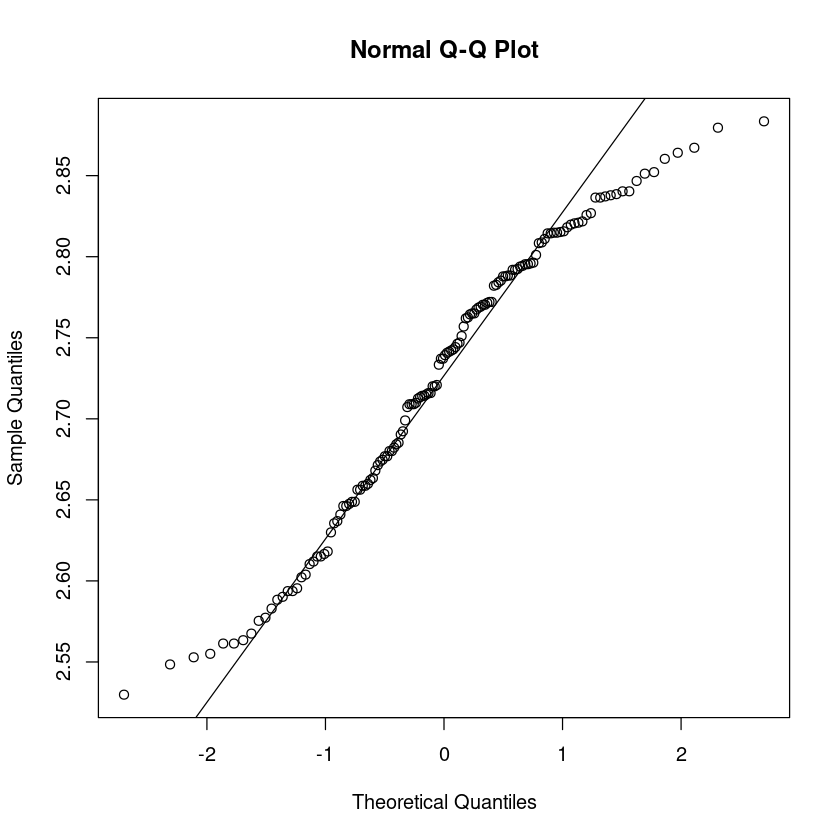

In [22]:
# Q-Q PLOT
qqnorm(tran_org)
qqline(tran_org)

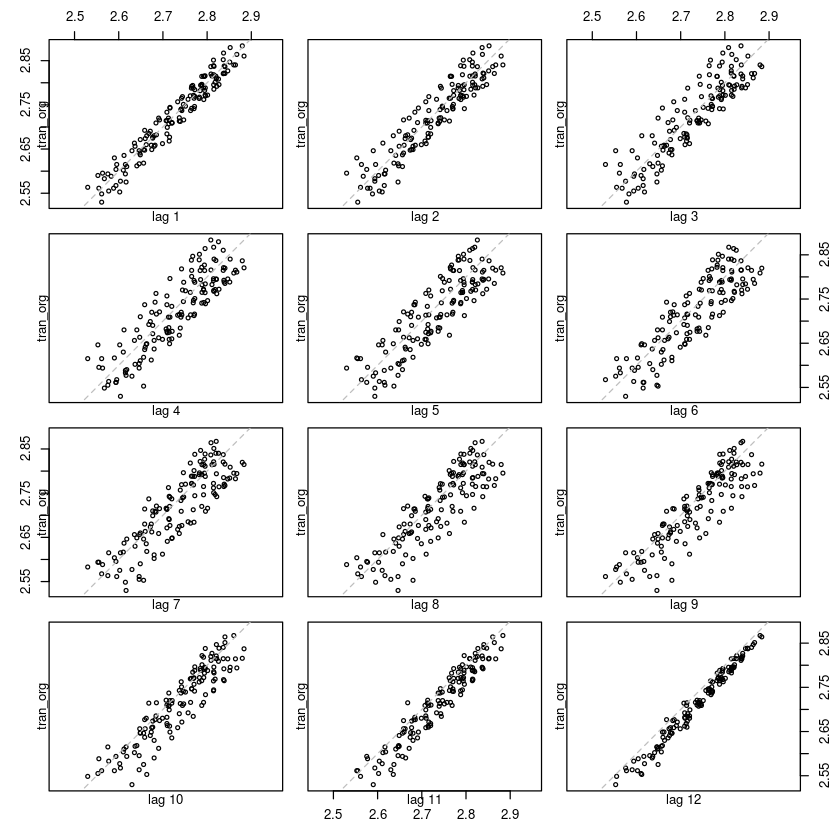

In [23]:
# 상관관계 확인
lag.plot(tran_org,12,do.lines=FALSE)
#전반적으로 데이터는 정규분포를 따르고 시차가 12일때 상관관계가 높음

- acf 확인

- lag=12

# 시계열 분해 및 회귀분석 이용 예측

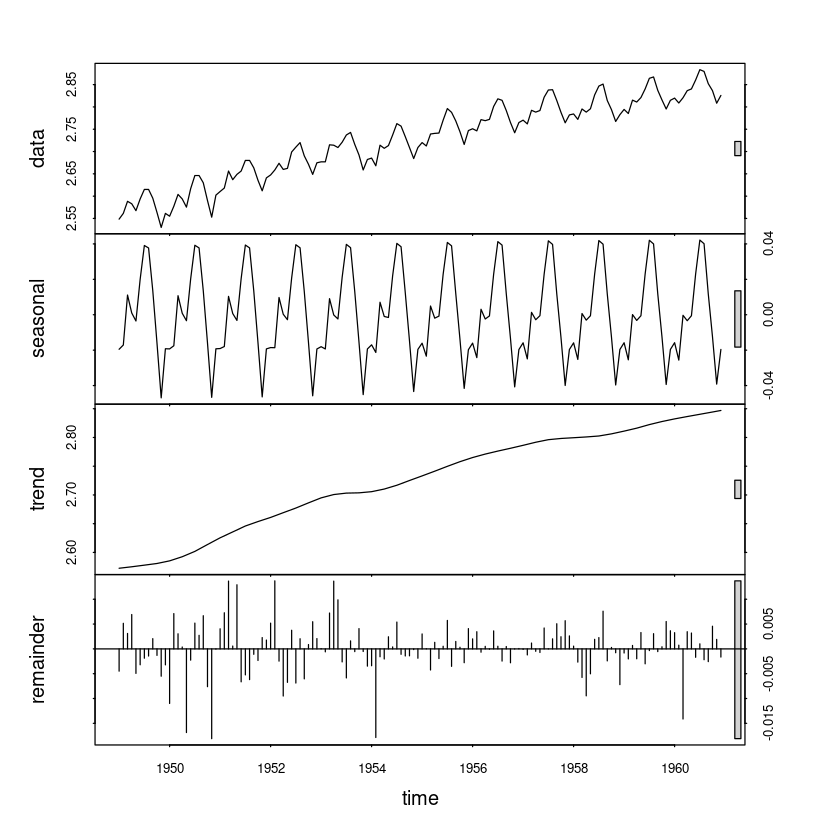

In [27]:
stl_tran_org <- stl(tran_org, s.window = 12)

plot(stl_tran_org)
# 1차 Trend와 Seasonality 존재
# 잔차는 White Noise로 판단

In [75]:
# 계절형 Dummy 변수 생성
M <- factor(cycle(tran_org))
stl_tran_org_df <- as.data.frame(stl_tran_org$time.series)

In [76]:
# 회귀 모형 생성
# 모형식 : tran_org=trend∗β1+M1∗d1+...+M11∗d11+ϵ
model_stl <- lm(formula = tran_org~ 0+stl_tran_org_df$trend+M, na.action = NULL)
summary(model_stl)


Call:
lm(formula = tran_org ~ 0 + stl_tran_org_df$trend + M, na.action = NULL)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0208982 -0.0030056  0.0003675  0.0032375  0.0186285 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
stl_tran_org_df$trend  1.003132   0.006557 152.982  < 2e-16 ***
M1                    -0.025890   0.017899  -1.446  0.15043    
M2                    -0.029141   0.017911  -1.627  0.10614    
M3                    -0.002850   0.017923  -0.159  0.87389    
M4                    -0.009503   0.017936  -0.530  0.59713    
M5                    -0.010617   0.017948  -0.592  0.55519    
M6                     0.012901   0.017961   0.718  0.47386    
M7                     0.032071   0.017974   1.784  0.07669 .  
M8                     0.030402   0.017986   1.690  0.09335 .  
M9                     0.004045   0.017998   0.225  0.82255    
M10                   -0.023032   0.018011  -1.279  0.20322    
M11          

In [80]:
cycle(tran_org) # gives the positions in the cycle of each observation.

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1949,1,2,3,4,5,6,7,8,9,10,11,12
1950,1,2,3,4,5,6,7,8,9,10,11,12
1951,1,2,3,4,5,6,7,8,9,10,11,12
1952,1,2,3,4,5,6,7,8,9,10,11,12
1953,1,2,3,4,5,6,7,8,9,10,11,12
1954,1,2,3,4,5,6,7,8,9,10,11,12
1955,1,2,3,4,5,6,7,8,9,10,11,12
1956,1,2,3,4,5,6,7,8,9,10,11,12
1957,1,2,3,4,5,6,7,8,9,10,11,12
1958,1,2,3,4,5,6,7,8,9,10,11,12


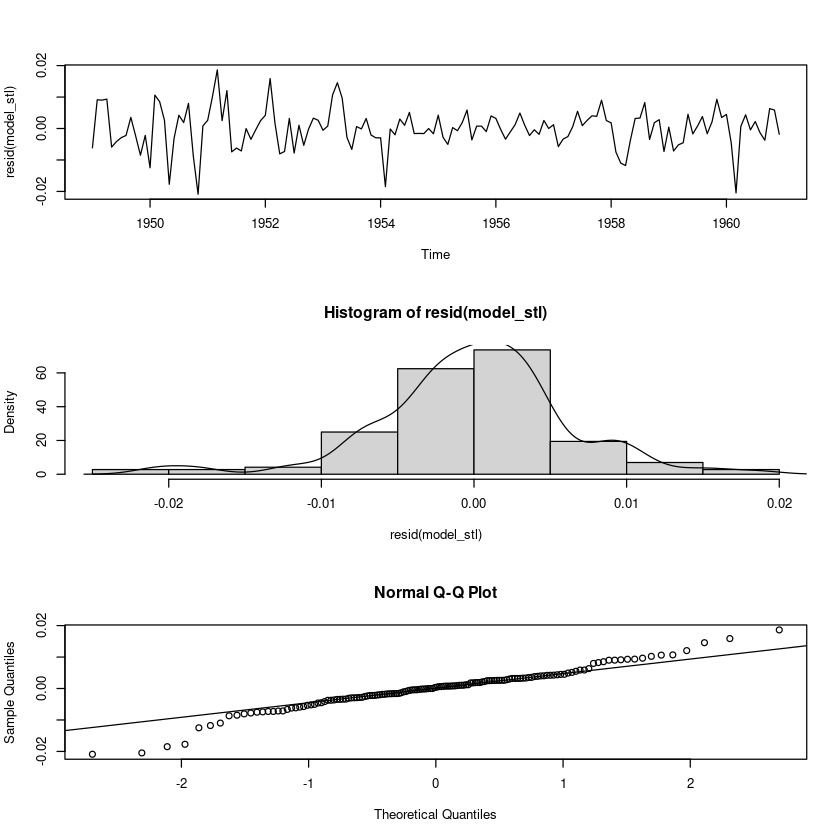

In [41]:
# 잔차 검정

par(mfrow=c(3,1))
# time Plot
plot(resid(model_stl))
# Hist Plot
hist(resid(model_stl),prob=TRUE,12)
lines(density(resid(model_stl)))
# Q-Q PLOT
qqnorm(resid(model_stl))
qqline(resid(model_stl))
# Q-Q Plot과 Histogram을 확인하면 양쪽 끝이 두텁지만 White Noise라고 판단하기 어려움이 없음


- 트렌드 분산 같이 잡고싶을 때

[1] 81.14211

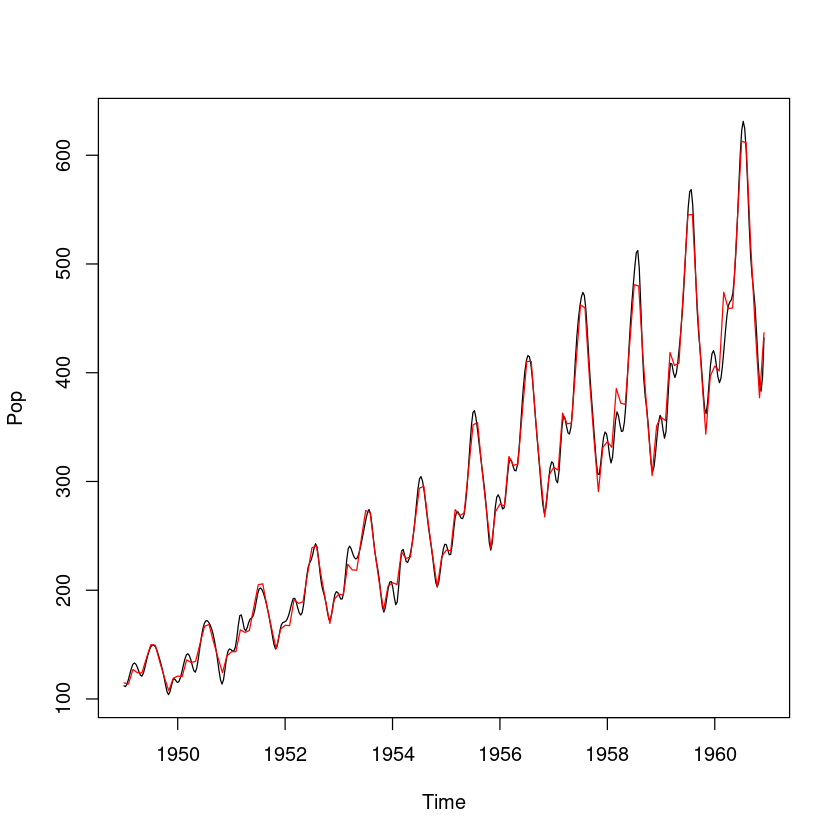

In [42]:
plot(spline(time(origin), origin),type='l',xlab='Time',ylab='Pop')

# 원 데이터 및 fitted 데이터의 비교
# BoxCox 역변환 필요 함
lines(InvBoxCox(model_stl$fitted.values, lambda = BoxCox.lambda(origin)), col='red')
mean((origin - InvBoxCox(model_stl$fitted.values, lambda = BoxCox.lambda(origin)))^2, na.rm = TRUE)

# 지수평활을 이용한 예측

- 단순 지수 평활: 추세나 계절적 변동이 없는 시계열 예측에 사용
- 이중 지수 평활: 추세만 존재하는 시계열 예측에 사용
- HoltWinters: 추세와 계절 요인이 있는 시계열 예측에 사용

이중 지수 평활을 확장한 개념으로 특정 기간 내의 계절성을 함께 고려 가능

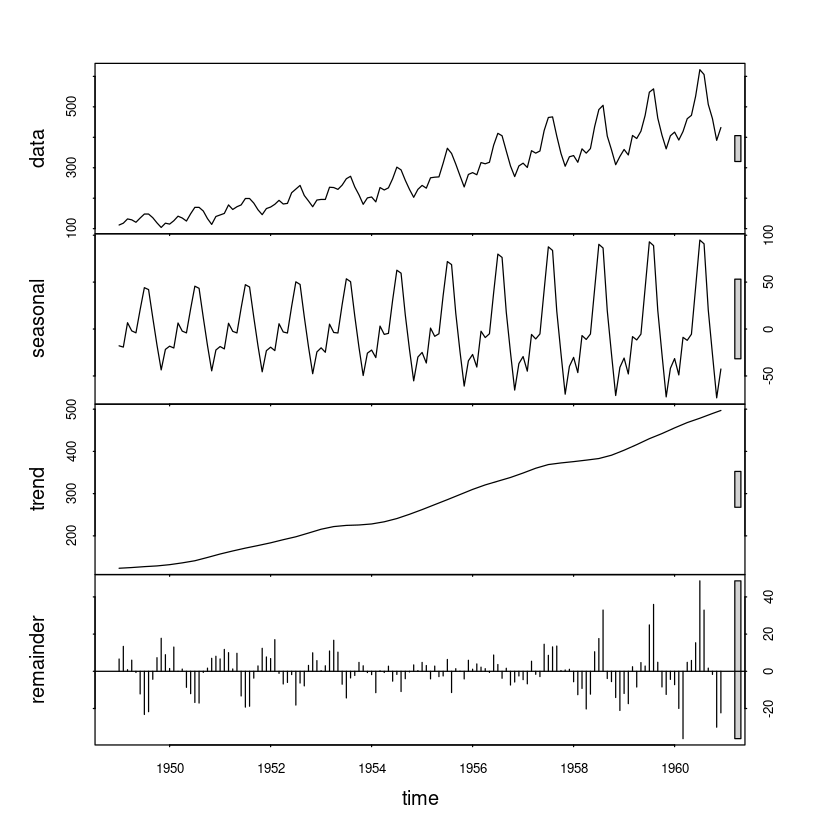

In [43]:
#============================================================
# 지수평활을 이용한 예측
#============================================================

plot(stl(origin, s.window=12))
# Trend 및 Seasonality 존재
# Holt-Winter 지수평활 모형이 적합

[1] 125.5362

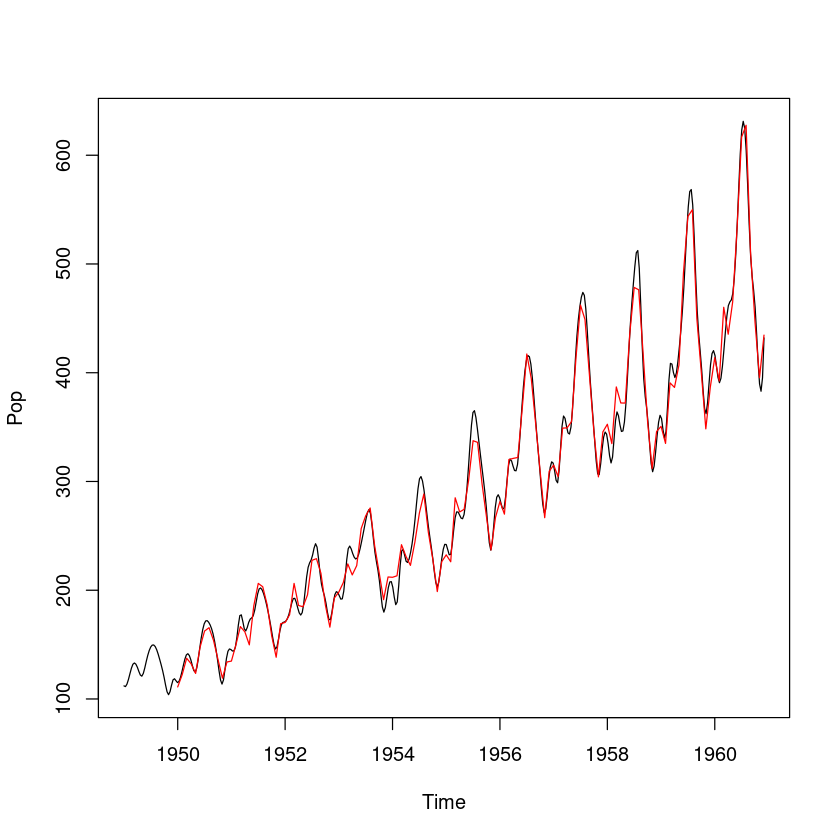

In [44]:
#HoltWinters 모형 생성
model_es <- HoltWinters(origin, seasonal = "multiplicative")

# 원 데이터 및 fitted 데이터의 비교
# plot
plot(spline(time(origin), origin),type='l',xlab='Time',ylab='Pop')
lines(model_es$fitted[,1], col='red')
# mse 125.5
mean((origin-model_es$fitted[,1])^2)

# ARIMA를 이용한 예측

- Seasonality 제거/ 차분인데 시즈널리티가 뚜렷하면 시즈널 제거...

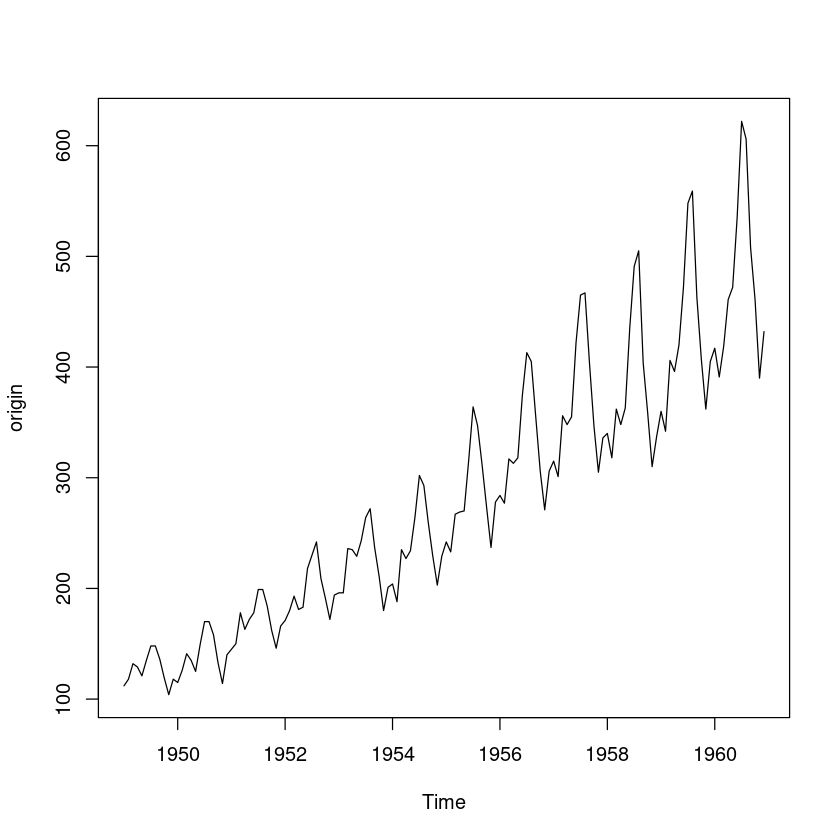

In [45]:
# 데이터 탐색 및 모형식별
# 시도표
plot(origin)
# 데이터의 이분산과 1차 추세가 존재함
# 분산 안정화를 위한 Box Cox 변환과 1차 차분 필요

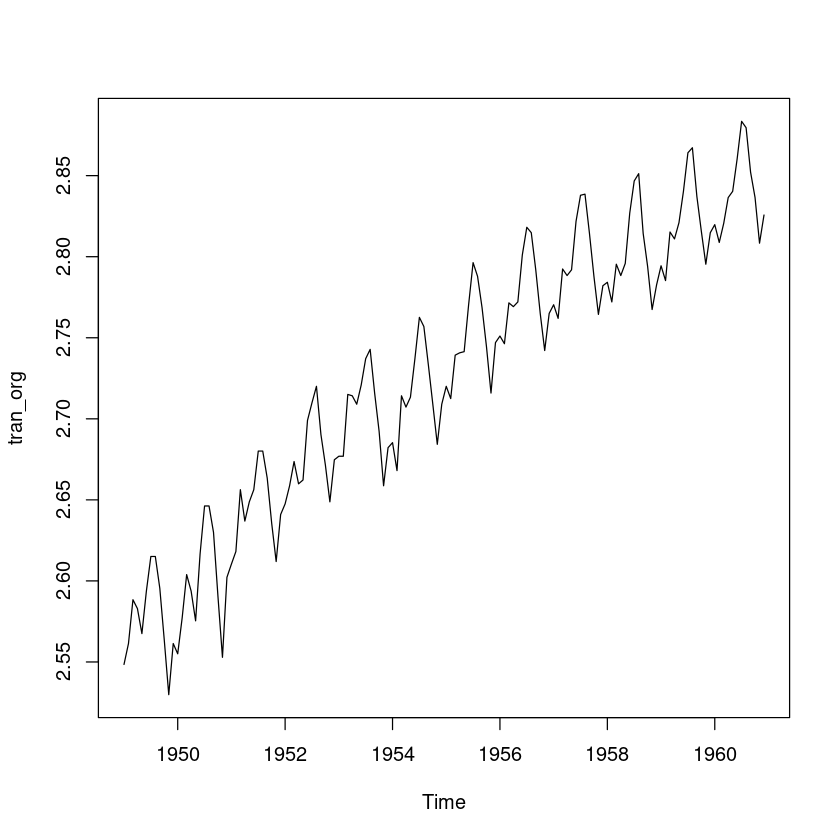

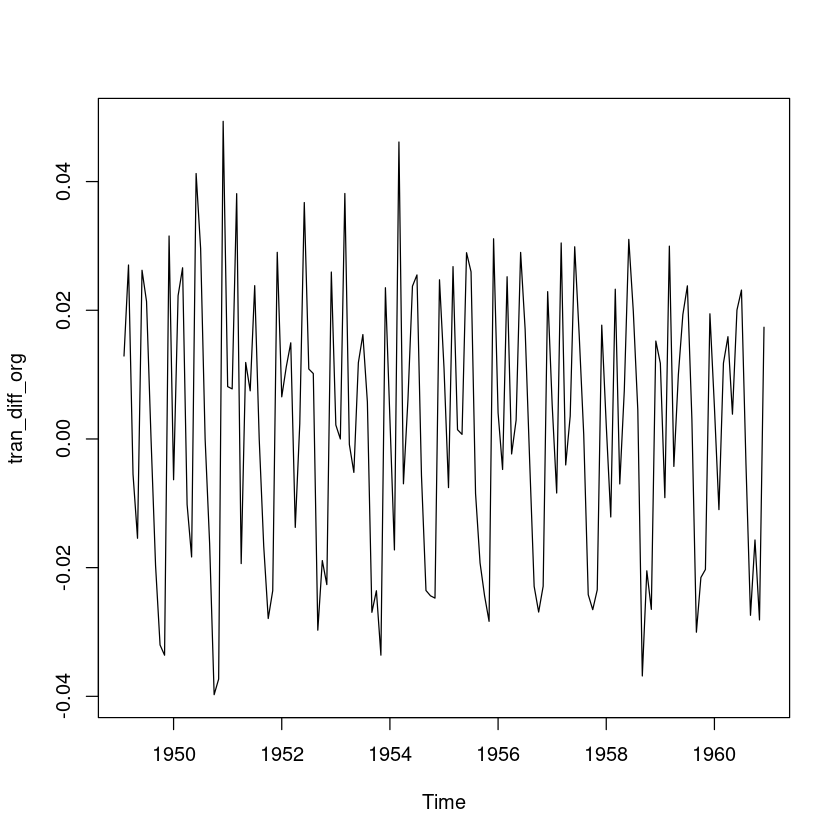

In [46]:
# 분산 안정화 및 차분
tran_org <- BoxCox(origin, BoxCox.lambda(origin))
plot(tran_org)
tran_diff_org <- diff(tran_org)
plot(tran_diff_org)

- 계절성을 먼저 제거하고 차분을 해야하는 케이스가 존재.
- 일반적으로는 차분을 먼저한다. 

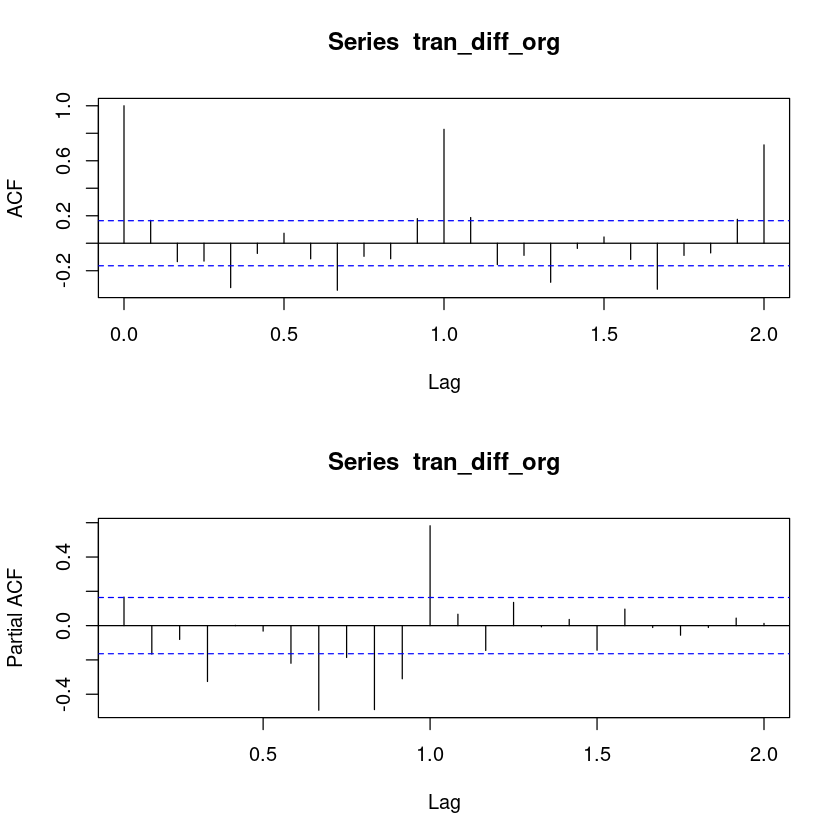

In [52]:
# ACF, PACF를 통한 탐색
layout(1:2)
acf(tran_diff_org, lag.max = 24)
pacf(tran_diff_org, lag.max=24)

In [54]:
# 계절 차분 및 ACF, PACF를 통한 탐색
tran_sdiff_org <- diff(tran_diff_org, lag = 12)

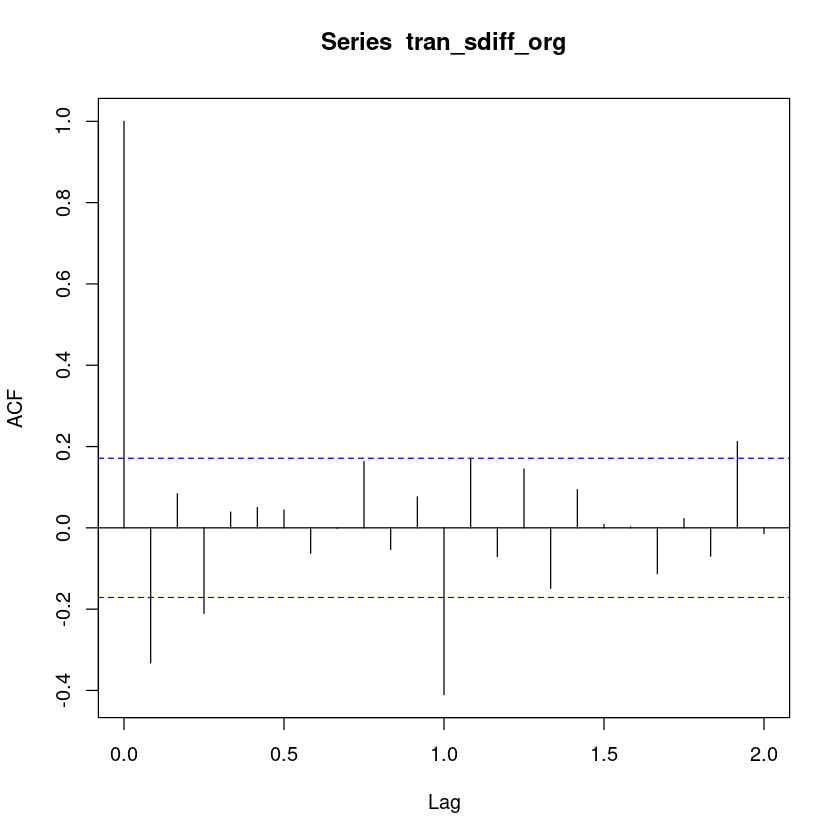

In [55]:
acf(tran_sdiff_org, lag.max = 24)
# acf는 lag=1,3,12에서 0이 아닌값 가짐  비계절 시차 4부터 절단 -> MA(3), 계절 -> 시차 2부터 절단 SMA(1)

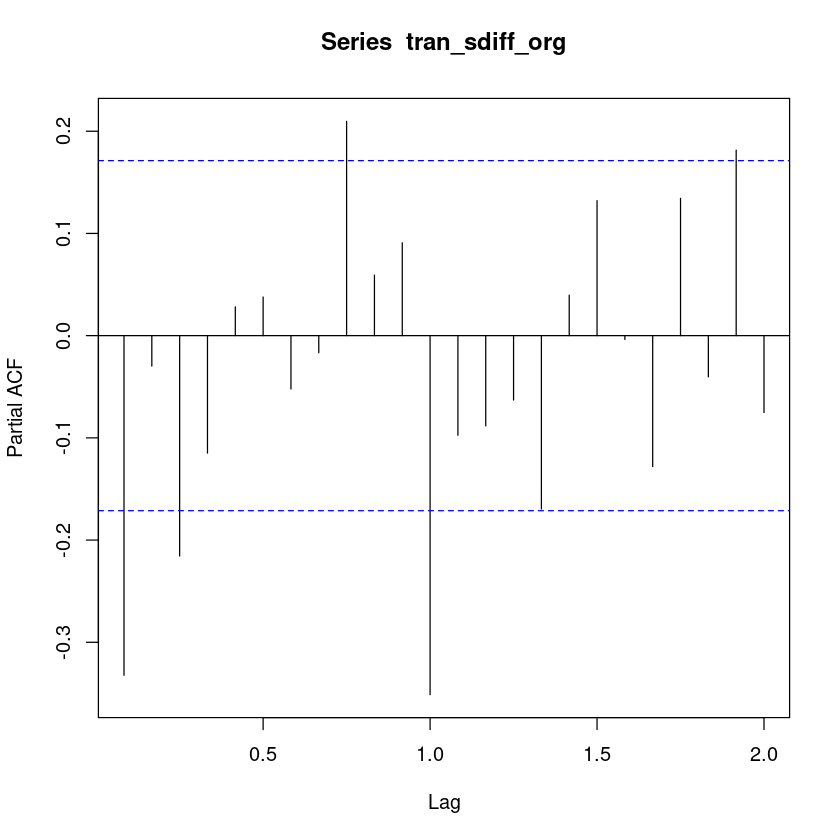

In [56]:
pacf(tran_sdiff_org, lag.max = 24)
# 시차 2와 8에서 0보다 큰 값을 가지지만 정확한 모형을 찾기 위해 auto.arima를 통해 aic가 최소가 되는 order 값 구함

In [57]:
auto.arima(tran_sdiff_org, max.p = 3, max.q=3, max.Q=1)
auto.arima(tran_org, max.p = 3, max.q=3, max.Q=1)
# 모형 구축

Series: tran_sdiff_org 
ARIMA(0,0,1)(0,0,1)[12] with zero mean 

Coefficients:
          ma1     sma1
      -0.4355  -0.5847
s.e.   0.0908   0.0725

sigma^2 = 5.789e-05:  log likelihood = 451.59
AIC=-897.18   AICc=-896.99   BIC=-888.55

Series: tran_org 
ARIMA(0,1,1)(0,1,1)[12] 

Coefficients:
          ma1     sma1
      -0.4355  -0.5847
s.e.   0.0908   0.0725

sigma^2 = 5.855e-05:  log likelihood = 451.6
AIC=-897.19   AICc=-897.01   BIC=-888.57

In [58]:
model_arima <- arima(tran_sdiff_org, order=c(0,0,1), seasonal = list(order = c(0,0,1), period = 12))
model_arima <- arima(tran_org, order=c(0,1,1), seasonal = list(order = c(0,1,1), period = 12))

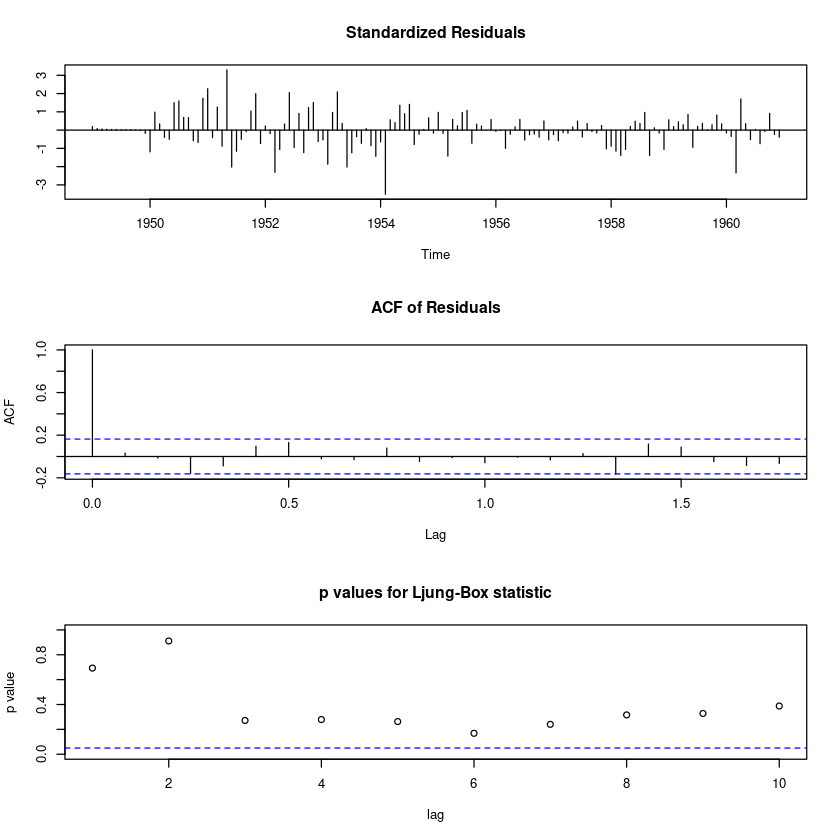

In [59]:
# 모형 검진
# 잔차 검정
tsdiag(model_arima)
# 독립성 검정

In [60]:
Box.test(model_arima$residuals, type="Ljung-Box")
# 잔차의 독립성, 등분산성, 정규성 만족


	Box-Ljung test

data:  model_arima$residuals
X-squared = 0.15595, df = 1, p-value = 0.6929


plot(spline(time(origin), origin),type='l',xlab='Time',ylab='Pop')

In [86]:
# spline ? underline function을 부드럽게 만드는 함수...

[1] 107.2414

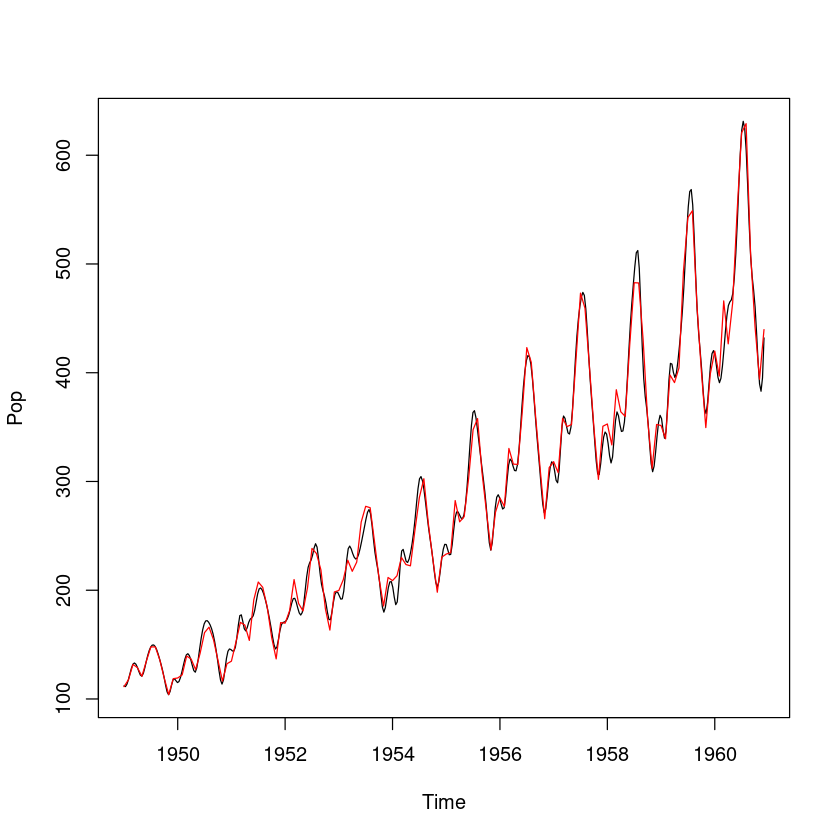

In [61]:
# 원 데이터 및 fitted 데이터의 비교
plot(spline(time(origin), origin),type='l',xlab='Time',ylab='Pop')
lines(InvBoxCox(fitted(model_arima), BoxCox.lambda(origin)), col='red')
mean((origin - InvBoxCox(fitted(model_arima), BoxCox.lambda(origin)))^2)

In [63]:
# 12개월 예측
arima_fit <- predict(model_arima, n.ahead=12) #BoxCox 변환 데이터 사용
lambda <- BoxCox.lambda(origin)

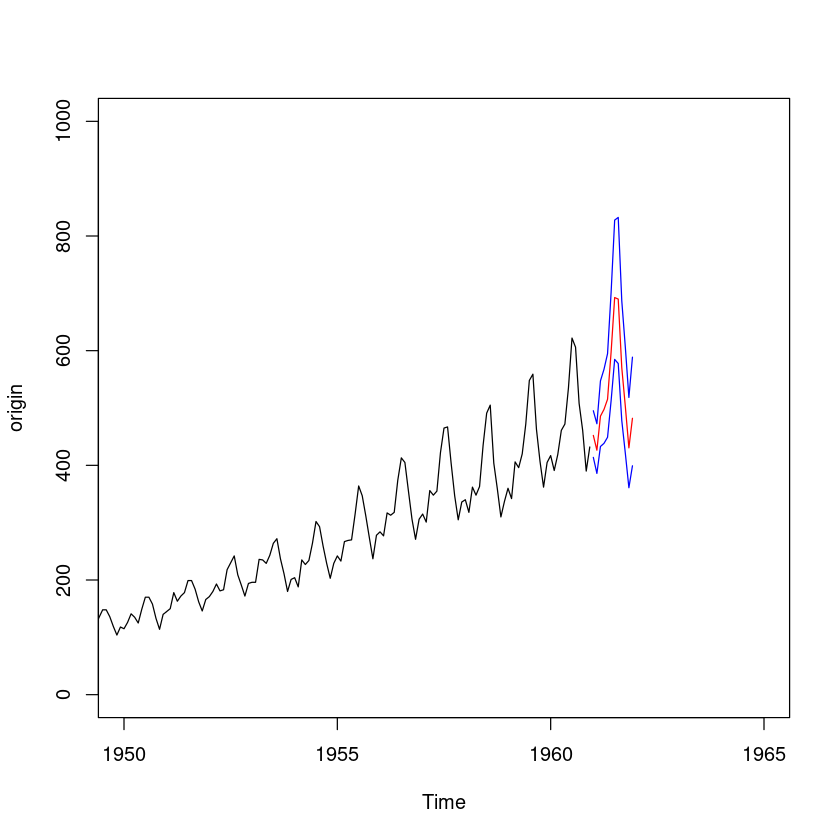

In [64]:
ts.plot(origin, xlim=c(1950,1965), ylim = c(0, 1000))
lines(InvBoxCox(arima_fit$pred, lambda),col="red")
lines(InvBoxCox(arima_fit$pred+1.96*arima_fit$se, lambda),col="blue",lty=1)
lines(InvBoxCox(arima_fit$pred-1.96*arima_fit$se, lambda),col="blue",lty=1)